# Jurnal Modul 3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

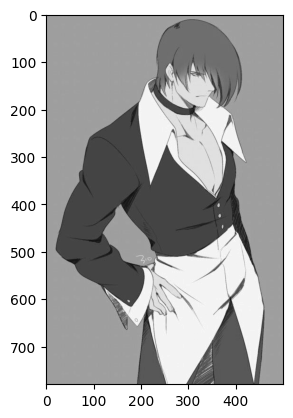

In [3]:
image = cv2.imread("IoriYagami.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap="gray")

### 1. Dekomposisi Citra pada Level 3, 4, 5 dan Seterusnya

In [4]:
LPF = np.array([0.7, 0.7])
HPF = np.array([-0.7, 0.7])

In [5]:
def padding_1(img, n):
    n = len(n) - 1
    result = np.pad(img, [(0, 0), (0, n)])
    return result

def padding_2(img, n):
    n = len(n) - 1
    result = np.pad(img, [(0, n), (0, 0)])
    return result

In [6]:
def filter_1 (matriks, filter, citra):
    konvol1 = np.zeros((citra.shape))
    for i in range (citra.shape[0]):
        for j in range (citra.shape[1]):
            for k in range (len(filter)):
                konvol1[i][j] += (matriks[i, j+k] * filter[k])
    return konvol1

def filter_2 (matriks, filter, citra):
    konvol1 = np.zeros((citra.shape))
    for i in range (citra.shape[0]):
        for j in range (citra.shape[1]):
            for k in range (len(filter)):
                konvol1[i][j] += (matriks[i+k, j] * filter[k])
    return konvol1

In [7]:
def downsampling_1 (array):
    baris = int(array.shape[0] / 2)
    kolom = int(array.shape[1])
    kernel1 = np.zeros((baris, kolom))
    index = 0
    for i in range (baris):
        for j in range (kolom):
            kernel1[i][j] = array[index][j]
        index = index + 2
    return kernel1

def downsampling_2(array):
    baris = int(array.shape[0])
    kolom = int(array.shape[1] / 2)
    kernel1 = np.zeros((baris, kolom))
    for i in range(baris):
        index = 0
        for j in range(kolom):
            kernel1[i][j] = array[i][index]
            index = index + 2
    return kernel1

In [8]:
def dekomposisi (citra, f1, f2):
    pad1 = padding_1 (citra, f1)
    konvolusi1 = filter_1(pad1, f1, citra)
    downsampling1 = downsampling_2(konvolusi1)
    pad2 = padding_2(downsampling1, f2)
    konvolusi2 = filter_2(pad2, f2, downsampling1)
    downsampling2 = downsampling_1(konvolusi2)
    approx = downsampling2
    return approx

In [9]:
def normalize_image(img):
    min_val = np.min(img)
    max_val = np.max(img)
    normalized_img = ((img - min_val) / (max_val - min_val)) * 255
    return normalized_img.astype(np.uint8)

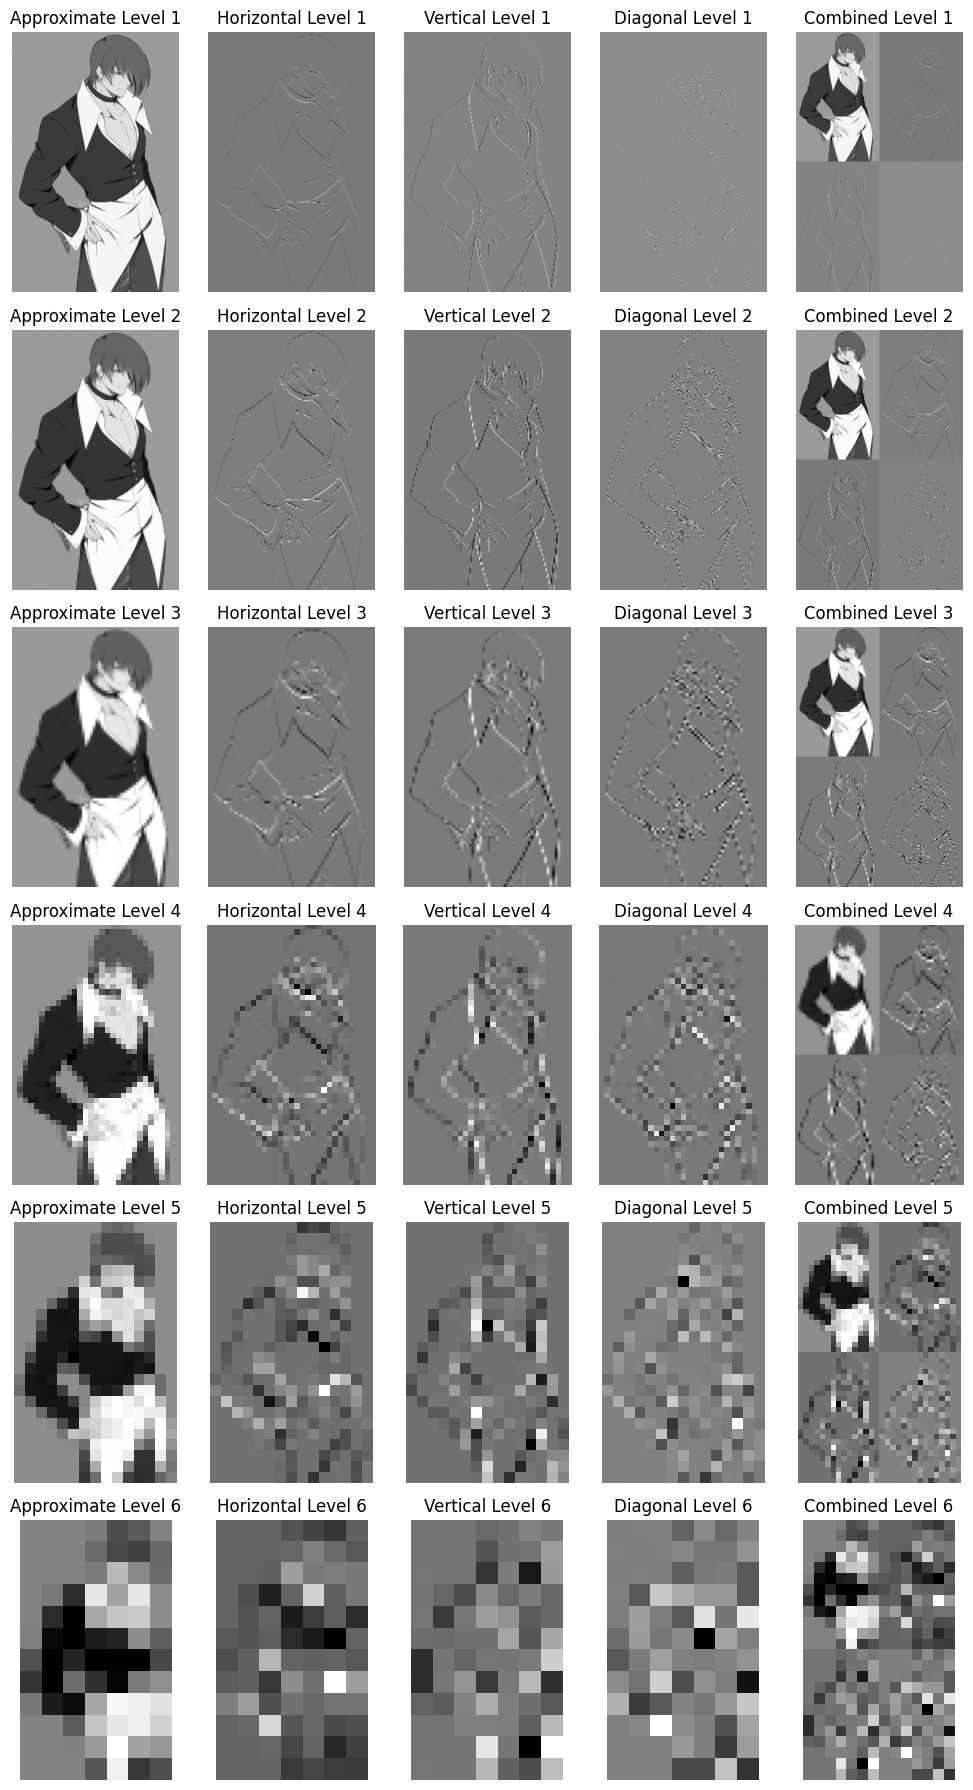

In [14]:
# input jumlah level dekomposisi
num_levels = 6  

# jumlah filter level
LL_levels = []
LH_levels = []
HL_levels = []
HH_levels = []
combined_levels = []

current_image = image
for level in range(1, num_levels + 1):
    
    # dekomposisi level - level
    LL = dekomposisi(current_image, LPF, LPF)
    LH = dekomposisi(current_image, LPF, HPF)
    HL = dekomposisi(current_image, HPF, LPF)
    HH = dekomposisi(current_image, HPF, HPF)
    
    # Menormalkan setiap komponen dan simpan dalam daftar masing-masing
    LL_levels.append(normalize_image(LL))
    LH_levels.append(normalize_image(LH))
    HL_levels.append(normalize_image(HL))
    HH_levels.append(normalize_image(HH))

    combined_img = np.vstack((
        np.hstack((LL_levels[-1], LH_levels[-1])),
        np.hstack((HL_levels[-1], HH_levels[-1]))
    ))
    combined_levels.append(normalize_image(combined_img))
        
    # perbarui gambar saat ini untuk dekomposisi tingkat berikutnya
    current_image = LL  # gunakan LL sebagai input untuk tingkat berikutnya

# menampilkan LL, LH, HL, HH, dan gambar gabungan untuk setiap level
fig, axes = plt.subplots(num_levels, 5, figsize=(10, 3*num_levels))

for level in range(num_levels):
    axes[level, 0].imshow(LL_levels[level], cmap='gray')
    axes[level, 0].set_title(f"Approximate Level {level+1}")
    axes[level, 0].axis('off')
    
    axes[level, 1].imshow(LH_levels[level], cmap='gray')
    axes[level, 1].set_title(f"Horizontal Level {level+1}")
    axes[level, 1].axis('off')
    
    axes[level, 2].imshow(HL_levels[level], cmap='gray')
    axes[level, 2].set_title(f"Vertical Level {level+1}")
    axes[level, 2].axis('off')
    
    axes[level, 3].imshow(HH_levels[level], cmap='gray')
    axes[level, 3].set_title(f"Diagonal Level {level+1}")
    axes[level, 3].axis('off')

    axes[level, 4].imshow(combined_levels[level], cmap='gray')
    axes[level, 4].set_title(f"Combined Level {level+1}")
    axes[level, 4].axis('off')
    

plt.tight_layout()
plt.show()


### 2. Rekonstruksi dari Hasil Dekomposisi

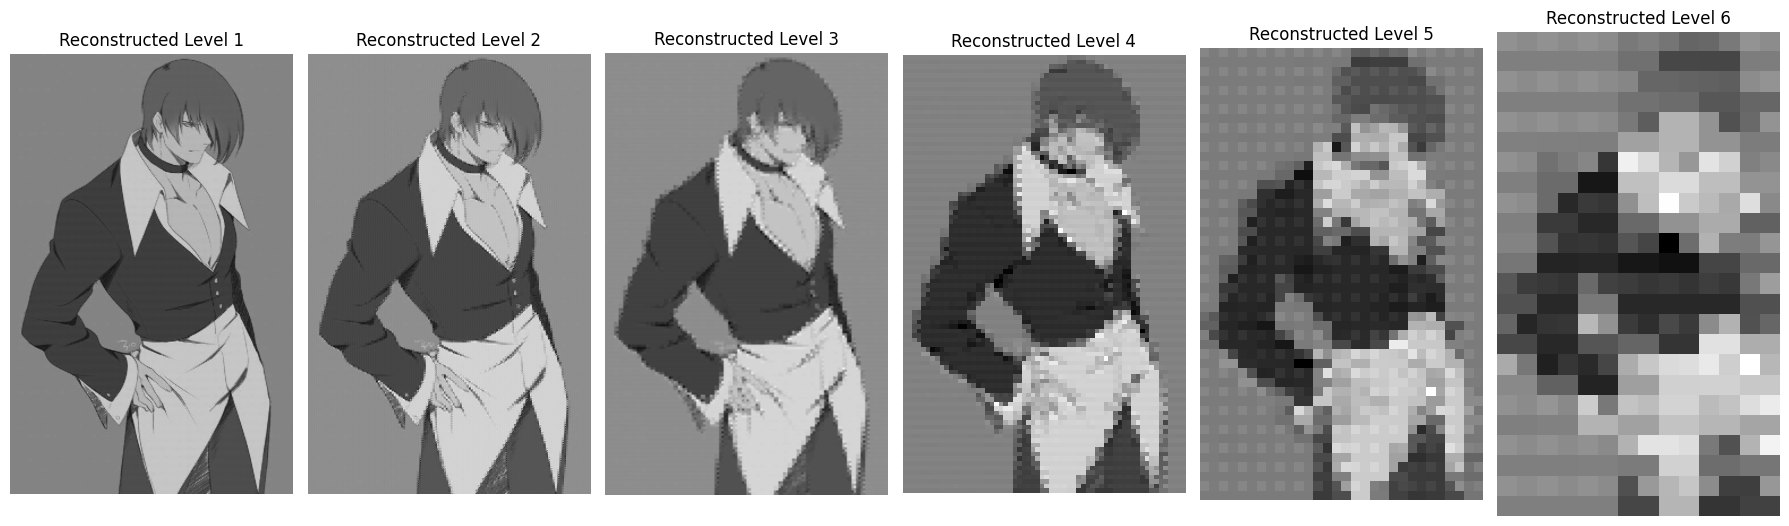

In [11]:
def rekonstruksi(down1, down2, down3, down4):
    tImage, lImage = down1.shape
    t = tImage * 2; l = lImage * 2
    image = np.zeros([t, l])
    LL, LH = np.zeros([t, l]), np.zeros([t, l])
    HL, HH = np.zeros([t, l]), np.zeros([t, l])

    for i in range (t // 2):
        for j in range (l // 2):
            LL[2*i][2*j] = down1[i][j]
            LH[2*i][2*j] = down2[i][j]
            HL[2*i][2*j] = down3[i][j]
            HH[2*i][2*j] = down4[i][j]

    for i in range(1, t, 2):
        for j in range(l):
            LL[i][j] = LL[i-1][j] + LH[i-1][j]
    
    for i in range(t):
        for j in range(1, l, 2):
            LL[i][j] = LL[i][j-1] + HL[i][j-1]
    
    for i in range(t):
        for j in range(l):
            image[i][j] = LL[i][j] + HH[i][j]
    
    return image

reconstructed_images = []
for i in range(num_levels):
    reconstructed_image = rekonstruksi(LL_levels[i], LH_levels[i], HL_levels[i], HH_levels[i])
    reconstructed_images.append(normalize_image(reconstructed_image))

# menampilkan hasil gambar rekonstruksi
fig, axes = plt.subplots(1, num_levels, figsize=(3*num_levels, 10))
for i in range(num_levels):
    axes[i].imshow(reconstructed_images[i], cmap='gray')
    axes[i].set_title(f"Reconstructed Level {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 3. Level berapa hasil dari dekomposisi

Pada gambar tersebut, hasil dekomposisi tersebut merupakan proses dari dekomposisi level 6 keatas. Hal ini dikarenakan dekomposisi merupakan proses untuk memecah gambar menjadi lebih sederhana. Pada gambar tersebut resolusi citra menjadi lebih kecil yang berarti proses dekomposisi citra terjadi pada level yang lebih tinggi yang kemungkinan berada di antara level 6 atau keatasnya seperti yang terlihat pada soal nomor 1 sebelumnya.

In [12]:
def get_amplitude_index(img):
    amplitude = (img - np.min(img)) * (255 / (np.max(img) - np.min(img)))
    index = np.arange(img.size).reshape(img.shape)

    return amplitude, index

num_levels = 6 

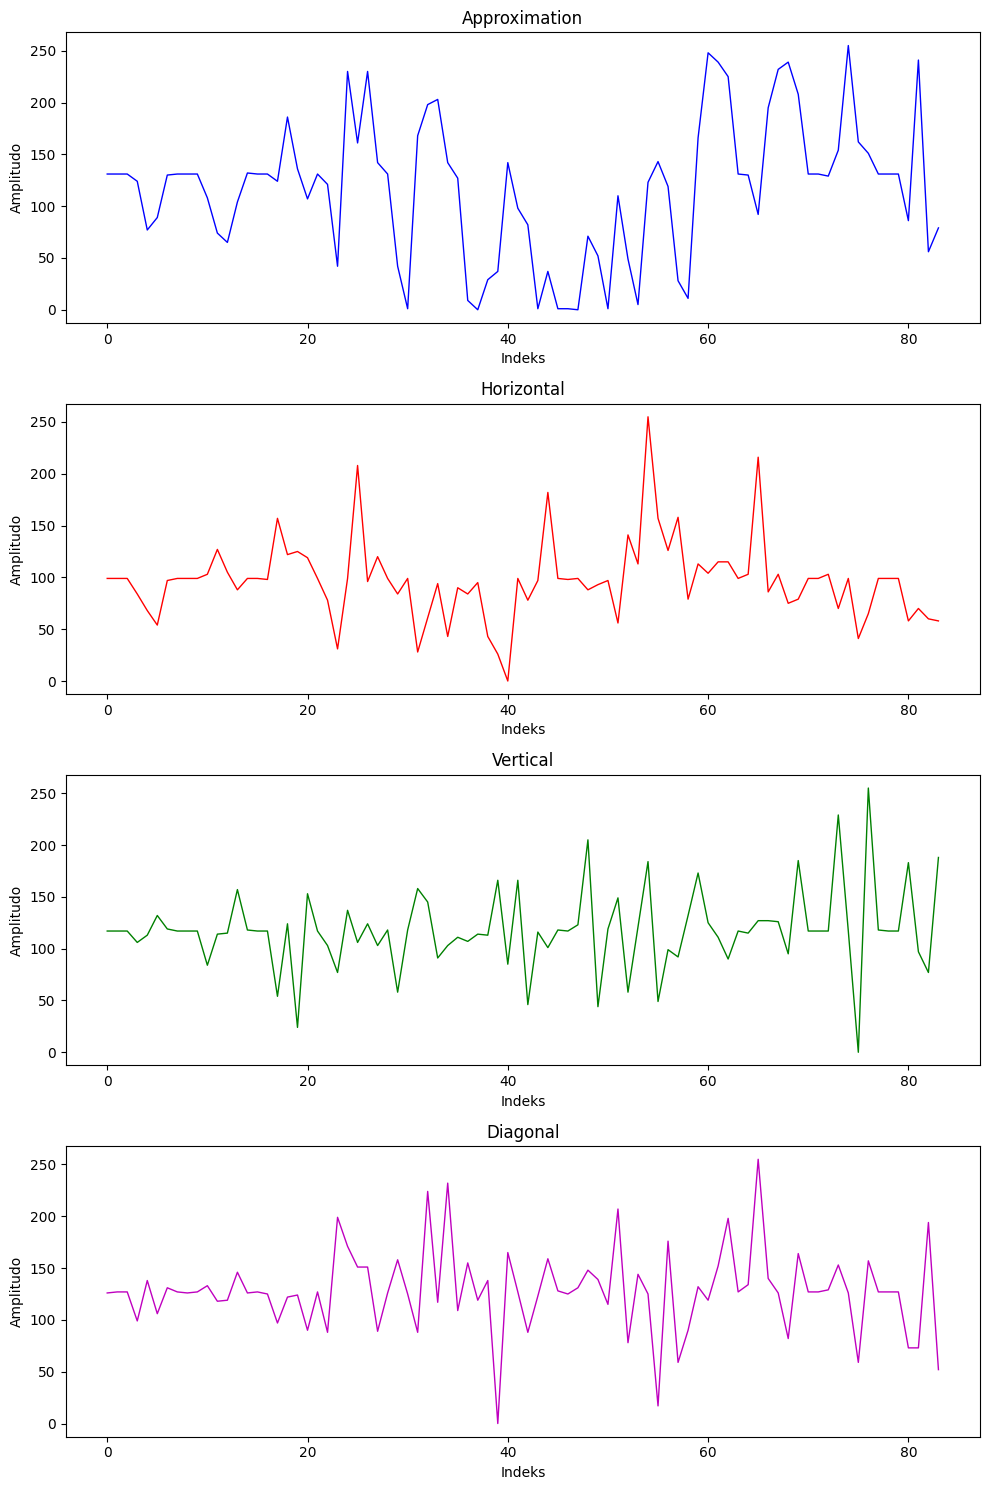

In [13]:
current_image = image
for level in range(1, num_levels + 1):
    
    LL = dekomposisi(current_image, LPF, LPF)
    LH = dekomposisi(current_image, LPF, HPF)
    HL = dekomposisi(current_image, HPF, LPF)
    HH = dekomposisi(current_image, HPF, HPF)
    
    LL_norm = normalize_image(LL)
    LH_norm = normalize_image(LH)
    HL_norm = normalize_image(HL)
    HH_norm = normalize_image(HH)
    
    if level == 6:
        LL_amp, LL_idx = get_amplitude_index(LL_norm)
        LH_amp, LH_idx = get_amplitude_index(LH_norm)
        HL_amp, HL_idx = get_amplitude_index(HL_norm)
        HH_amp, HH_idx = get_amplitude_index(HH_norm)
        
        fig, axes = plt.subplots(4, 1, figsize=(10, 15))
        
        axes[0].plot(LL_idx.flatten(), LL_amp.flatten(), 'b-', linewidth=1)
        axes[0].set_title("Approximation")
        axes[0].set_xlabel("Indeks")
        axes[0].set_ylabel("Amplitudo")
        
        axes[1].plot(LH_idx.flatten(), LH_amp.flatten(), 'r-', linewidth=1)
        axes[1].set_title("Horizontal")
        axes[1].set_xlabel("Indeks")
        axes[1].set_ylabel("Amplitudo")
        
        axes[2].plot(HL_idx.flatten(), HL_amp.flatten(), 'g-', linewidth=1)
        axes[2].set_title("Vertical")
        axes[2].set_xlabel("Indeks")
        axes[2].set_ylabel("Amplitudo")
        
        axes[3].plot(HH_idx.flatten(), HH_amp.flatten(), 'm-', linewidth=1)
        axes[3].set_title("Diagonal")
        axes[3].set_xlabel("Indeks")
        axes[3].set_ylabel("Amplitudo")
        
        plt.tight_layout()
        plt.show()
    
    current_image = LL 